In [1]:
import torch

import numpy as np
from pymc import InverseGamma

from sbi.analysis import pairplot
from sbi.inference import NPE,NLE

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from torch.distributions import Normal, Independent,InverseGamma

In [2]:
num_dim = 1  # Here, num_dim = 1, indicating we have one parameter σ^2

# Define the simulator function
# torch.randn: Generates random numbers following a standard normal distribution (mean = 0, standard deviation = 1).

def simulator(theta, n=1000):
    # theta[0] is σ^2
    mu, sigma2 = 0, theta[0]
    sigma = np.sqrt(sigma2)
    return mu + sigma * torch.randn(n)  # Generate n observations


In [3]:
prior = Independent(InverseGamma(torch.tensor([2.0]), torch.tensor([1.0])), 1)

In [4]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)
# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)
# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [5]:
inference = NPE(prior=prior)

# get test data
num_simulations = 500
theta = prior.sample((num_simulations,))
x = simulator(theta)

print("theta.shape", theta.shape)
print("x.shape", x.shape)

theta.shape torch.Size([500, 1])
x.shape torch.Size([500, 1000])


In [6]:
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

 Neural network successfully converged after 185 epochs.

In [7]:
posterior = inference.build_posterior(density_estimator)

/opt/anaconda3/envs/SBI_project/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


In [8]:
# # 手动设置 theta 的真实值
theta_true = torch.tensor([[0.3]])  # sigma^2 = 0.3
x_obs = simulator(theta_true)
samples = posterior.sample((1000,), x=x_obs)


Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

In [9]:
import numpy as np

# 先验参数
alpha_0 = 2
beta_0 = 1  # 先验方差

# 数据准备
Z = x_obs.numpy()  # 如果是 PyTorch 张量，转换为 NumPy 数组
Z_flat = Z.flatten()  # 展平成一维数组

# 样本均值和样本数量
Y_mean = np.mean(Z_flat)  # 样本均值
n = Z.size  # 样本数量

# 计算样本的总方差
variance = np.sum((Z_flat - Y_mean) ** 2) 

# 后验均值 μ'
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + variance / 2 

# 输出结果
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)


Posterior alpha: 502.0
Posterior beta: 154.50759887695312


In [10]:
import numpy as np

# Prior parameters
alpha_0 = 2
beta_0 = 1  # Prior scale parameter

# Data preparation
Z = x_obs.numpy()  # If PyTorch tensor, convert to NumPy array
Z_flat = Z.flatten()  # Flatten to a one-dimensional array

# Sample mean and sample size
Y_mean = np.mean(Z_flat)  # Sample mean
n = Z.size  # Sample size

# Calculate total sample variance
variance = np.sum((Z_flat - Y_mean) ** 2) 

# Posterior parameters
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + variance / 2 

# Output results
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)


Posterior alpha: 502.0
Posterior beta: 154.50759887695312


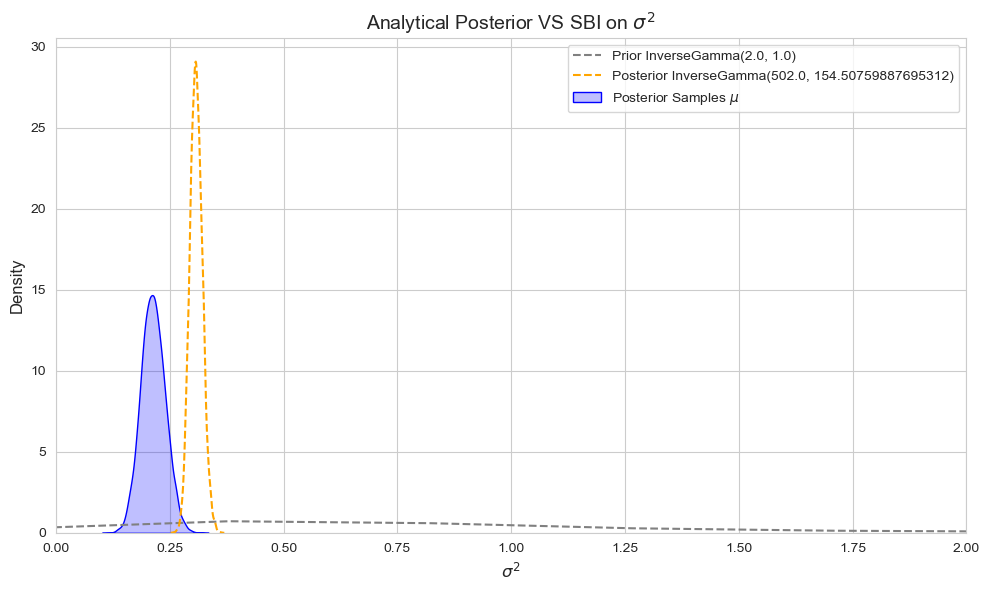

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Assume alpha_poster and beta_poster are already defined
alpha_prior = 2.0  # Inverse Gamma shape parameter α
beta_prior = 1.0   # Inverse Gamma rate parameter β

# Sample from the Inverse Gamma distribution
# Inverse Gamma samples are generated by taking the reciprocal of Gamma samples
gamma_samples = np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=10000)
inverse_gamma_samples = 1 / gamma_samples  # Convert to Inverse Gamma samples

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the KDE for the Prior Inverse Gamma distribution
sns.kdeplot(inverse_gamma_samples, ax=ax, label=f"Prior InverseGamma({alpha_prior}, {beta_prior})", color="grey", linestyle="--")

# Sample from the Posterior Inverse Gamma distribution
gamma_samples = np.random.gamma(shape=alpha_poster, scale=1 / beta_poster, size=10000)
inverse_gamma_samples = 1 / gamma_samples
sns.kdeplot(inverse_gamma_samples, ax=ax, label=f"Posterior InverseGamma({alpha_poster}, {beta_poster})", color="orange", linestyle="--")

# Extract the first dimension of the samples (e.g., $\mu$)
mu_samples = samples[:, 0].numpy()
sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$", color="blue")

# Add legend, title, and labels
ax.set_title("Analytical Posterior VS SBI on $\sigma^2$", fontsize=14)
ax.set_xlabel(r"$\sigma^2$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# Set x-axis range
ax.set_xlim(0, 2)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
theta_true = torch.tensor([[1]])  # sigma^2 = 1.0
x_obs = simulator(theta_true)
samples = posterior.sample((1000,), x=x_obs)


Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

In [75]:
import numpy as np

# Prior parameters
alpha_0 = 2
beta_0 = 1  # Prior scale parameter

# Data preparation
Z = x_obs.numpy()  # If PyTorch tensor, convert to NumPy array
Z_flat = Z.flatten()  # Flatten to a one-dimensional array

# Sample mean and sample size
Y_mean = np.mean(Z_flat)  # Sample mean
n = Z.size  # Sample size

# Calculate total sample variance
variance = np.sum((Z_flat - Y_mean) ** 2) 

# Posterior parameters
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + variance / 2 

# Output results
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)


Posterior alpha: 502.0
Posterior beta: 484.373291015625


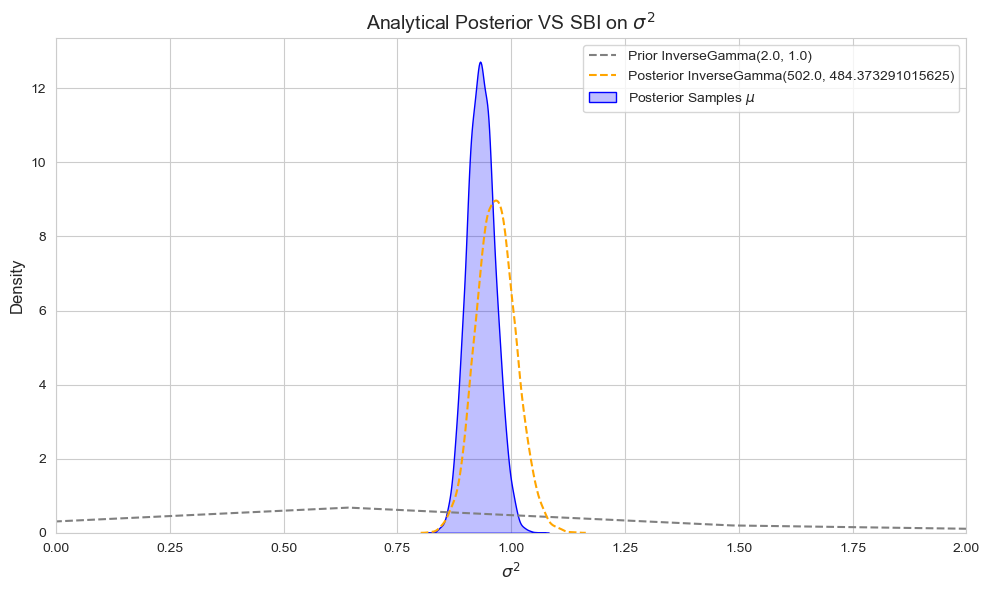

In [76]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Assume alpha_poster and beta_poster are already defined
alpha_prior = 2.0  # Inverse Gamma shape parameter α
beta_prior = 1.0   # Inverse Gamma rate parameter β

# Sample from the Inverse Gamma distribution
# Inverse Gamma samples are generated by taking the reciprocal of Gamma samples
gamma_samples = np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=10000)
inverse_gamma_samples = 1 / gamma_samples  # Convert to Inverse Gamma samples

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the KDE for the Prior Inverse Gamma distribution
sns.kdeplot(inverse_gamma_samples, ax=ax, label=f"Prior InverseGamma({alpha_prior}, {beta_prior})", color="grey", linestyle="--")

# Sample from the Posterior Inverse Gamma distribution
gamma_samples = np.random.gamma(shape=alpha_poster, scale=1 / beta_poster, size=10000)
inverse_gamma_samples = 1 / gamma_samples
sns.kdeplot(inverse_gamma_samples, ax=ax, label=f"Posterior InverseGamma({alpha_poster}, {beta_poster})", color="orange", linestyle="--")

# Extract the first dimension of the samples (e.g., $\mu$)
mu_samples = samples[:, 0].numpy()
sns.kdeplot(mu_samples, ax=ax, fill=True, label=r"Posterior Samples $\mu$", color="blue")

# Add legend, title, and labels
ax.set_title("Analytical Posterior VS SBI on $\sigma^2$", fontsize=14)
ax.set_xlabel(r"$\sigma^2$", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)

# Set x-axis range
ax.set_xlim(0, 2)

# Show the plot
plt.tight_layout()
plt.show()
